https://thecleverprogrammer.com/2020/07/12/employee-turnover-prediction/

In [43]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report
from sklearn.feature_selection import RFE

In [44]:
# Loading the dataset

df = pd.read_csv('emp_turn_over.csv').rename(columns={'sales': 'job_type','average_montly_hours': 'average_monthly_hours'})


# Giving a unique id for each employee

emp_id = ['EMP'+str(i) for i in range(1,len(df)+1)]
df['emp_id'] = emp_id

df = df[['emp_id','satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'job_type', 'salary','left']]


# Display first 5 rows of data
print("Shape of Dataset :",df.shape)
df.head()

Shape of Dataset : (14999, 11)


,emp_id,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,job_type,salary,left
0,EMP1,0.38,0.53,2,157,3,0,0,sales,low,1
1,EMP2,0.80,0.86,5,262,6,0,0,sales,medium,1
2,EMP3,0.11,0.88,7,272,4,0,0,sales,medium,1
3,EMP4,0.72,0.87,5,223,5,0,0,sales,low,1
4,EMP5,0.37,0.52,2,159,3,0,0,sales,low,1


# Variable Identification

In [45]:
# Function returning Categorical columns

def cat_cols(df):
    return list(df.select_dtypes(include='object').columns)

print("Categorical Columns :\n",cat_cols(df))

# Function returning Numerical columns

def num_cols(df):
    return list(df.select_dtypes(include=np.number).columns)

print("\nNumerical Columns :\n",num_cols(df))


Categorical Columns :
 ['emp_id', 'job_type', 'salary']

Numerical Columns :
 ['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'time_spend_company', 'Work_accident', 'promotion_last_5years', 'left']


In [46]:
# Info about data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 11 columns):
emp_id                   14999 non-null object
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_monthly_hours    14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
promotion_last_5years    14999 non-null int64
job_type                 14999 non-null object
salary                   14999 non-null object
left                     14999 non-null int64
dtypes: float64(2), int64(6), object(3)
memory usage: 1.3+ MB


In [47]:
# Statistics of the data

df.describe()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,left
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.021268,0.238083
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.144281,0.425924
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


# Exploratory Data Analysis

## Univariate Analysis

In [48]:
# Function to plot histograms

def hist_plotter(df,column,title,color='blue'):
    
    plt.figure(figsize=[9,7])
    plt.hist(df[column],color=color)
    plt.title("Histogram of " + title,fontsize=20)
    plt.xlabel(column,fontsize=17)
    plt.ylabel("Count",fontsize=17)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    return plt.show()

In [49]:
# Function to plot countplots

def count_plotter(df,column,title,rotation=0):
    
    plt.figure(figsize=[9,7])
    sns.countplot(df[column])
    plt.title("Countplot of " + title,fontsize=20)
    plt.xlabel(column,fontsize=17)
    plt.ylabel("Count",fontsize=17)
    plt.xticks(fontsize=14,rotation=rotation)
    plt.yticks(fontsize=14)
    
    return plt.show()

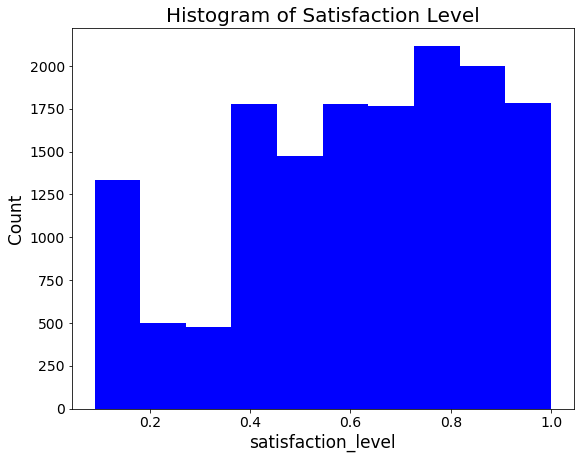

In [50]:
# Histogram for Satisfaction level of Employees

hist_plotter(df,'satisfaction_level',"Satisfaction Level")

In [51]:
# Assuming 0.5 as the boundary, checking how many employees are satisfied / not satisfied with their jobs

print("Number of Employees NOT Satisfied with the job :",len(df[df.satisfaction_level<0.5]))
print("\nNumber of Employees Satisfied with the job :",len(df[df.satisfaction_level>=0.5]))

Number of Employees NOT Satisfied with the job : 4583

Number of Employees Satisfied with the job : 10416


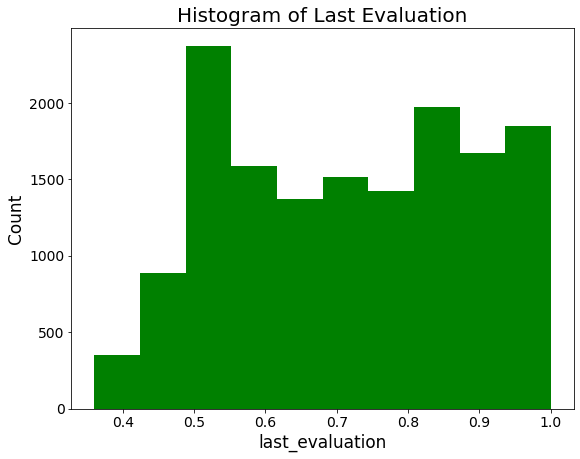

In [52]:
# Histogram for last evaluaton of  employees

hist_plotter(df,'last_evaluation','Last Evaluation','green')

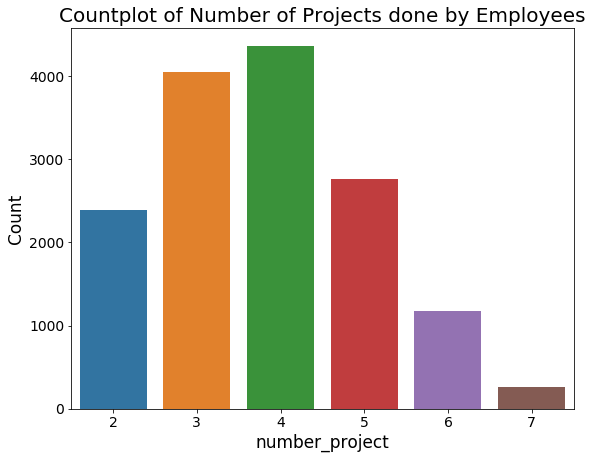

In [53]:
# Countplot of projects done by Employees

count_plotter(df,'number_project','Number of Projects done by Employees')

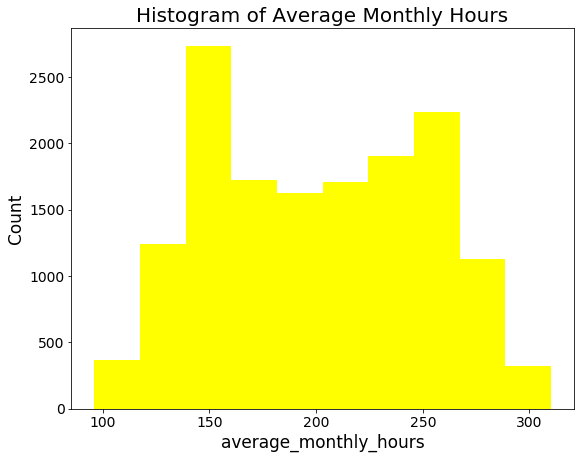

In [54]:
# Histogram for Average monthly hours by an Employee

hist_plotter(df,'average_monthly_hours','Average Monthly Hours','yellow')

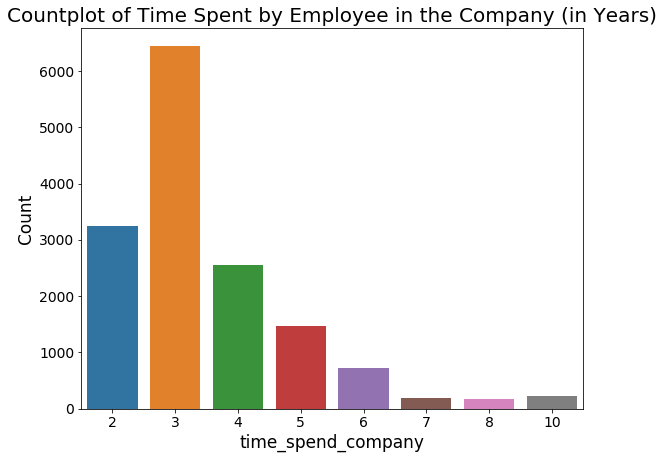

In [55]:
# Countplot for number of years an Employee has spent in the company

count_plotter(df,'time_spend_company','Time Spent by Employee in the Company (in Years)')

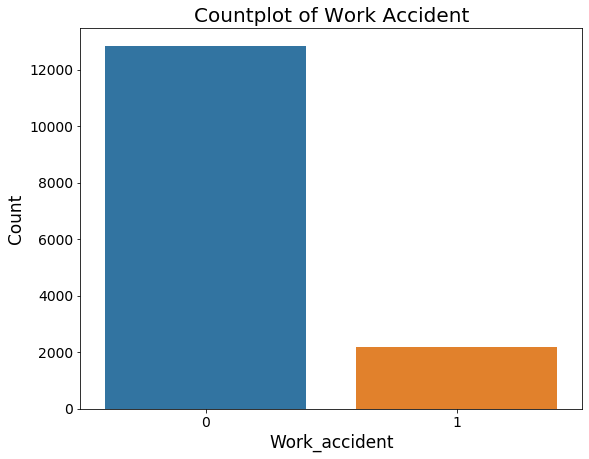

In [56]:
# Countplot of Work Accidents occured with Employees

count_plotter(df,'Work_accident','Work Accident')

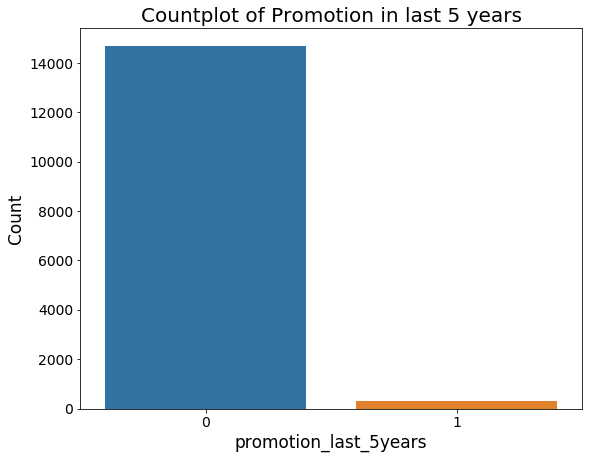

In [57]:
# Countplot showing whether Employee received a promotion in last 5 years

count_plotter(df,'promotion_last_5years','Promotion in last 5 years')

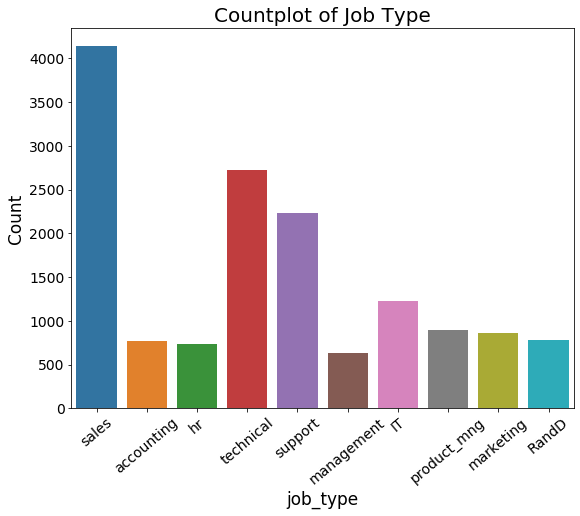

In [58]:
# Countplot of Job type of Employees

count_plotter(df,'job_type','Job Type',40)

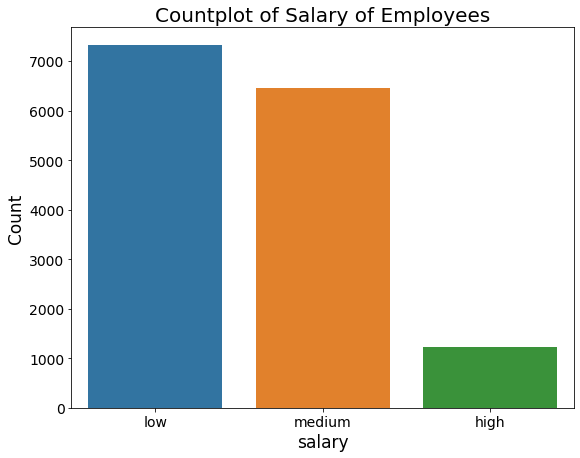

In [59]:
# Countplot of Salary of Employees

count_plotter(df,'salary','Salary of Employees')

## Multivariate Analysis

In [60]:
# View first 5 rows of dataset

df.head()

,emp_id,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,job_type,salary,left
0,EMP1,0.38,0.53,2,157,3,0,0,sales,low,1
1,EMP2,0.80,0.86,5,262,6,0,0,sales,medium,1
2,EMP3,0.11,0.88,7,272,4,0,0,sales,medium,1
3,EMP4,0.72,0.87,5,223,5,0,0,sales,low,1
4,EMP5,0.37,0.52,2,159,3,0,0,sales,low,1


In [61]:
# Function for creating boxplots

def box_plotter(df,col1,col2,title):
    
    plt.figure(figsize=[9,7])
    sns.boxplot(x=col1,y=df[col2],data=df)
    plt.title("\nBoxplot for {0}".format(title),fontsize=20)
    plt.xlabel(col1,fontsize=17)
    plt.ylabel(col2,fontsize=17)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    return plt.show() 

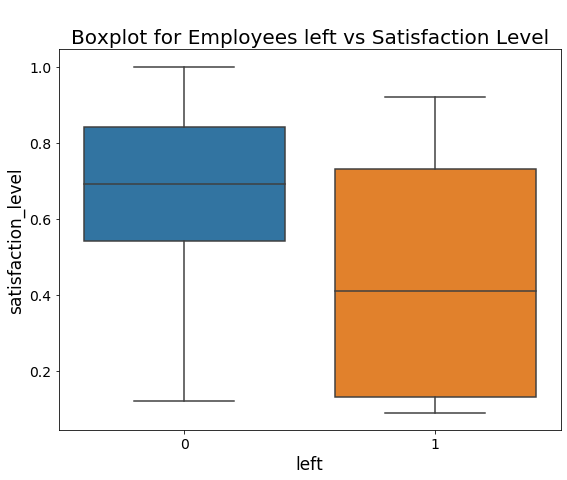

In [62]:
# Examining whether satisfaction level is a factor for employees leaving the organization

box_plotter(df,'left','satisfaction_level','Employees left vs Satisfaction Level')

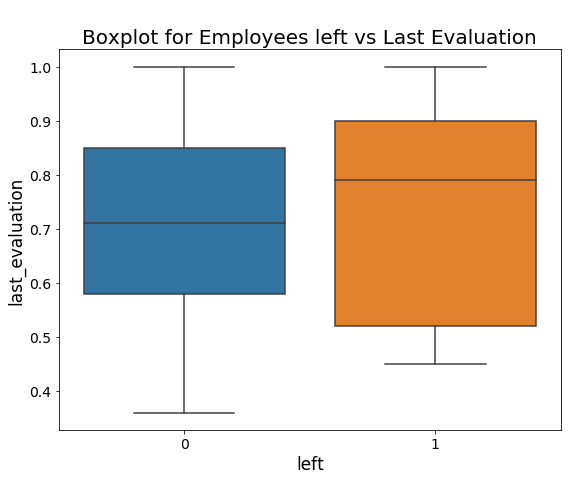

In [63]:
# Checking if Last evaluation has a role in the leaving of Employees

box_plotter(df,'left','last_evaluation','Employees left vs Last Evaluation')

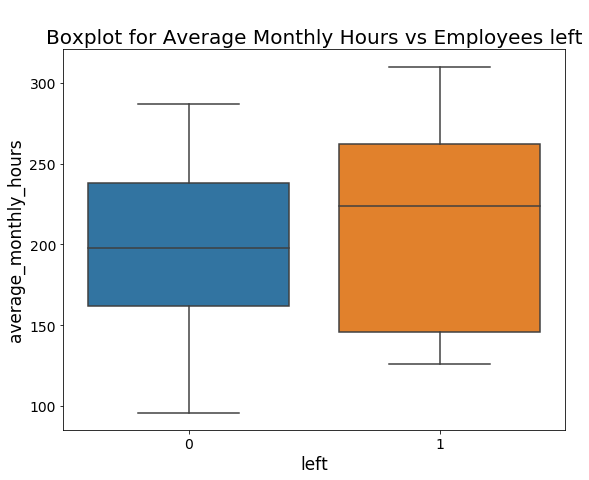

In [64]:
# Checking average monthly hours put by employees who left vs employyees still working

box_plotter(df,'left','average_monthly_hours','Average Monthly Hours vs Employees left')

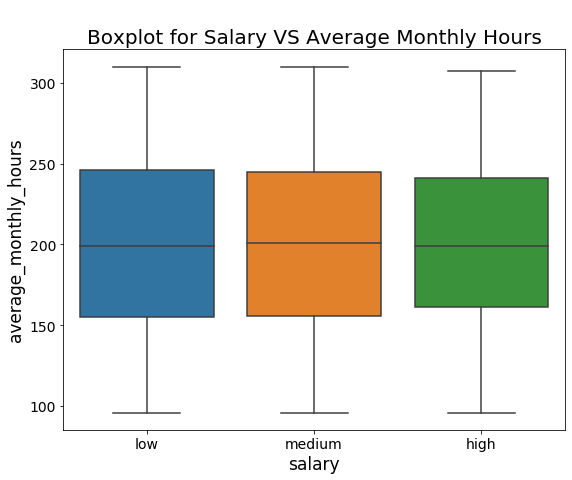

In [65]:
# Boxplot for monthly average working hours to salary of the employee

box_plotter(df,'salary','average_monthly_hours','Salary VS Average Monthly Hours')

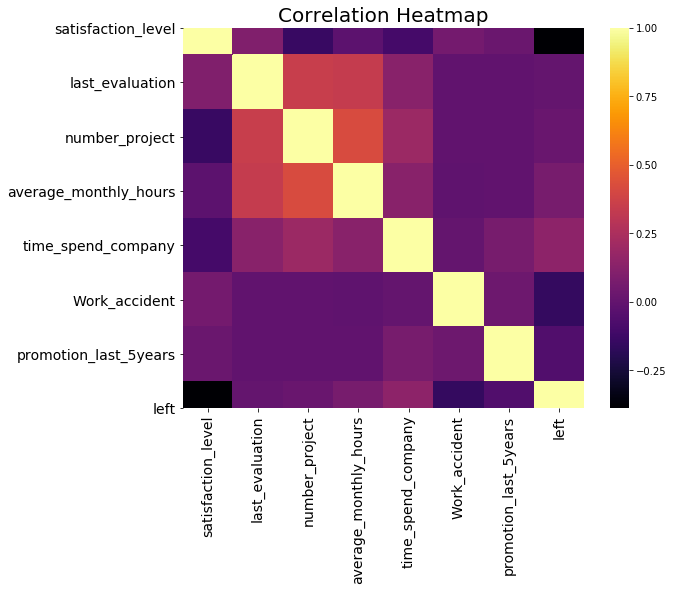

In [66]:
# Correlation Heatmap of the data

plt.figure(figsize=[9,7])
sns.heatmap(df.corr(),cmap='inferno')
plt.title('Correlation Heatmap',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

# Missing Values

In [67]:
# Function for viewing number of missing values in a column

def missing_values(df):
    missing = df.isnull().sum()
    percent = df.isnull().sum()/len(df)*100
    return pd.DataFrame({'Missing Count':missing,'Percentage':percent})

missing_values(df)

,Missing Count,Percentage
emp_id,0,0.0
satisfaction_level,0,0.0
last_evaluation,0,0.0
number_project,0,0.0
average_monthly_hours,0,0.0
time_spend_company,0,0.0
Work_accident,0,0.0
promotion_last_5years,0,0.0
job_type,0,0.0
salary,0,0.0


# Preprocessing

In [68]:
# Checking all types of job

df.job_type.value_counts()

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: job_type, dtype: int64

In [69]:
# Combining support, IT and technical job types into a single type i.e. "Technical"

df['job_type'] = np.where(df['job_type']=='support','technical',df['job_type'])
df['job_type'] = np.where(df['job_type']=='IT','technical',df['job_type'])

df.head()

,emp_id,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,job_type,salary,left
0,EMP1,0.38,0.53,2,157,3,0,0,sales,low,1
1,EMP2,0.80,0.86,5,262,6,0,0,sales,medium,1
2,EMP3,0.11,0.88,7,272,4,0,0,sales,medium,1
3,EMP4,0.72,0.87,5,223,5,0,0,sales,low,1
4,EMP5,0.37,0.52,2,159,3,0,0,sales,low,1


In [70]:
# Splitting Data into features and target

X = df.drop(columns=['emp_id','left'])
y = df.left

# Train Test Split of data

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0,stratify=y)

In [71]:
# Encoding training and test features

X_train = pd.get_dummies(X_train,drop_first=True)
X_test = pd.get_dummies(X_test,drop_first=True)

In [72]:
# Scaling the features 

scalar = MinMaxScaler()

X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)

# Model Building

In [73]:
# Linear Regression

logistic = LogisticRegression()
logistic.fit(X_train_scaled,y_train)
logistic_pred = logistic.predict(X_test_scaled)
print("Accuracy Score : ",accuracy_score(y_test,logistic_pred))
print("\nF1 Score : ",f1_score(y_test,logistic_pred))
print("\nConfusion Matrix : \n",confusion_matrix(y_test,logistic_pred))


Accuracy Score :  0.7913333333333333

F1 Score :  0.4499121265377856

Confusion Matrix : 
 [[3177  252]
 [ 687  384]]


In [74]:
sorted(sklearn.metrics.SCORERS.keys())

<IPython.core.display.Javascript object>

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [75]:
cross_val_score(estimator=logistic, X=X_train_scaled, y=y_train, scoring='accuracy', cv=5)

array([0.79666667, 0.79666667, 0.79428571, 0.79619048, 0.80276322])

In [76]:
# Feature Selection using RFE

model = RandomForestClassifier()
rfe = RFE(model,10)
rfe.fit(X_train,y_train)
print(rfe.support_)
selected_columns = pd.Series(index=X_train.columns,data=rfe.ranking_).sort_values()
selected_columns = list(selected_columns[selected_columns==1].index)
print(selected_columns)

[ True  True  True  True  True  True False False False False False False
  True  True  True  True]
['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'time_spend_company', 'Work_accident', 'job_type_sales', 'job_type_technical', 'salary_low', 'salary_medium']


In [77]:
# Random Forest

rf = RandomForestClassifier()
rf.fit(X_train[selected_columns],y_train)
rf_pred = rf.predict(X_test[selected_columns])
print("Accuracy Score : ",accuracy_score(y_test,rf_pred))
print("\nF1 Score : ",f1_score(y_test,rf_pred))
print("\nConfusion Matrix : \n",confusion_matrix(y_test,rf_pred))

Accuracy Score :  0.9922222222222222

F1 Score :  0.9834671705243269

Confusion Matrix : 
 [[3424    5]
 [  30 1041]]


In [78]:
# Cross Value score for Random Forest (Accuracy)

cross_val_score(estimator=rf, X=X_train[selected_columns], y=y_train, scoring='accuracy', cv=5)

array([0.9852381 , 0.98714286, 0.99095238, 0.98904762, 0.9890424 ])

In [79]:
# Cross Value score for Random Forest (F1 Score)

cross_val_score(estimator=rf, X=X_train[selected_columns], y=y_train, scoring='f1', cv=5)

array([0.9694501 , 0.97131148, 0.97979798, 0.97556008, 0.97669706])

In [80]:
# Grid Search/ Randomized Search Parameters

# Creating a Random Forest Classifier Object

random = RandomForestClassifier()

# Parameters for Hyperparameter Tuning

n_est = [i for i in range(100,501,50)]
criteria = ['gini','entropy']
max_depth = [i for i in range(2,15)]
min_samples_split = [2,3,5]
min_samples_leaf = [1,2,3]
bootstrap = [True,False]
max_features = ['auto','sqrt','log2',None]

# Creating a paramter grid for Grid Search

params_grid = {'n_estimators': n_est,
              'criterion': criteria,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf':min_samples_leaf,
              'bootstrap':bootstrap,
              'max_features':max_features,
              'n_jobs':[-1]}


In [81]:
# Grid Search Object

# grid = GridSearchCV(random,param_grid=params_grid,scoring='accuracy',cv=3,verbose=2)
# grid.fit(X_train,y_train)

In [ ]:
# Randomized Search for Hyperparamter tuning

random_search = RandomizedSearchCV(estimator=random,param_distributions=params_grid,
                                   n_iter=200,scoring='accuracy',cv=3,verbose=2)
random_search.fit(X_train[selected_columns],y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV] n_jobs=-1, n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=8, criterion=entropy, bootstrap=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_jobs=-1, n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=8, criterion=entropy, bootstrap=False, total=   1.2s
[CV] n_jobs=-1, n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=8, criterion=entropy, bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV]  n_jobs=-1, n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=8, criterion=entropy, bootstrap=False, total=   1.3s
[CV] n_jobs=-1, n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=8, criterion=entropy, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=8, criterion=entropy, bootstrap=False, total=   1.2s
[CV] n_jobs=-1, n_estimators=400, min_samples_split=2, min_samples_leaf=3, max_features=None, max_depth=11, criterion=gini, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=400, min_samples_split=2, min_samples_leaf=3, max_features=None, max_depth=11, criterion=gini, bootstrap=False, total=   4.0s
[CV] n_jobs=-1, n_estimators=400, min_samples_split=2, min_samples_leaf=3, max_features=None, max_depth=11, criterion=gini, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=400, min_samples_split=2, min_samples_leaf=3, max_features=None, max_dept

[CV]  n_jobs=-1, n_estimators=350, min_samples_split=5, min_samples_leaf=3, max_features=log2, max_depth=13, criterion=gini, bootstrap=True, total=   1.7s
[CV] n_jobs=-1, n_estimators=350, min_samples_split=3, min_samples_leaf=2, max_features=None, max_depth=14, criterion=gini, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=350, min_samples_split=3, min_samples_leaf=2, max_features=None, max_depth=14, criterion=gini, bootstrap=False, total=   4.2s
[CV] n_jobs=-1, n_estimators=350, min_samples_split=3, min_samples_leaf=2, max_features=None, max_depth=14, criterion=gini, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=350, min_samples_split=3, min_samples_leaf=2, max_features=None, max_depth=14, criterion=gini, bootstrap=False, total=   3.9s
[CV] n_jobs=-1, n_estimators=350, min_samples_split=3, min_samples_leaf=2, max_features=None, max_depth=14, criterion=gini, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=350, min_samples_split=3, min_samples_leaf=2, max_features=None, max_depth=14, c

[CV]  n_jobs=-1, n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=14, criterion=entropy, bootstrap=False, total=   0.9s
[CV] n_jobs=-1, n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=14, criterion=entropy, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=14, criterion=entropy, bootstrap=False, total=   0.9s
[CV] n_jobs=-1, n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=14, criterion=entropy, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=14, criterion=entropy, bootstrap=False, total=   0.9s
[CV] n_jobs=-1, n_estimators=100, min_samples_split=5, min_samples_leaf=3, max_features=log2, max_depth=8, criterion=entropy, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=100, min_samples_split=5, min_samples_leaf=3, max_features=log

[CV]  n_jobs=-1, n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=3, criterion=entropy, bootstrap=False, total=   0.4s
[CV] n_jobs=-1, n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=3, criterion=entropy, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=3, criterion=entropy, bootstrap=False, total=   0.4s
[CV] n_jobs=-1, n_estimators=250, min_samples_split=2, min_samples_leaf=3, max_features=auto, max_depth=12, criterion=entropy, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=250, min_samples_split=2, min_samples_leaf=3, max_features=auto, max_depth=12, criterion=entropy, bootstrap=False, total=   1.4s
[CV] n_jobs=-1, n_estimators=250, min_samples_split=2, min_samples_leaf=3, max_features=auto, max_depth=12, criterion=entropy, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=250, min_samples_split=2, min_samples_leaf=3, max_features=auto,

[CV]  n_jobs=-1, n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=13, criterion=gini, bootstrap=False, total=   1.9s
[CV] n_jobs=-1, n_estimators=500, min_samples_split=3, min_samples_leaf=1, max_features=log2, max_depth=14, criterion=gini, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=500, min_samples_split=3, min_samples_leaf=1, max_features=log2, max_depth=14, criterion=gini, bootstrap=False, total=   2.8s
[CV] n_jobs=-1, n_estimators=500, min_samples_split=3, min_samples_leaf=1, max_features=log2, max_depth=14, criterion=gini, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=500, min_samples_split=3, min_samples_leaf=1, max_features=log2, max_depth=14, criterion=gini, bootstrap=False, total=   3.4s
[CV] n_jobs=-1, n_estimators=500, min_samples_split=3, min_samples_leaf=1, max_features=log2, max_depth=14, criterion=gini, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=500, min_samples_split=3, min_samples_leaf=1, max_features=log2, max_depth=14, 

[CV]  n_jobs=-1, n_estimators=150, min_samples_split=3, min_samples_leaf=2, max_features=None, max_depth=11, criterion=entropy, bootstrap=False, total=   1.3s
[CV] n_jobs=-1, n_estimators=150, min_samples_split=3, min_samples_leaf=2, max_features=None, max_depth=11, criterion=entropy, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=150, min_samples_split=3, min_samples_leaf=2, max_features=None, max_depth=11, criterion=entropy, bootstrap=False, total=   1.3s
[CV] n_jobs=-1, n_estimators=150, min_samples_split=3, min_samples_leaf=2, max_features=None, max_depth=11, criterion=entropy, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=150, min_samples_split=3, min_samples_leaf=2, max_features=None, max_depth=11, criterion=entropy, bootstrap=False, total=   1.4s
[CV] n_jobs=-1, n_estimators=350, min_samples_split=5, min_samples_leaf=3, max_features=None, max_depth=8, criterion=entropy, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=350, min_samples_split=5, min_samples_leaf=3, max_features=Non

[CV]  n_jobs=-1, n_estimators=450, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=14, criterion=gini, bootstrap=True, total=   1.7s
[CV] n_jobs=-1, n_estimators=450, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=14, criterion=gini, bootstrap=True 
[CV]  n_jobs=-1, n_estimators=450, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=14, criterion=gini, bootstrap=True, total=   1.7s
[CV] n_jobs=-1, n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=6, criterion=gini, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=6, criterion=gini, bootstrap=False, total=   0.9s
[CV] n_jobs=-1, n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=6, criterion=gini, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=6, criteri

[CV]  n_jobs=-1, n_estimators=350, min_samples_split=2, min_samples_leaf=3, max_features=None, max_depth=4, criterion=gini, bootstrap=True, total=   1.5s
[CV] n_jobs=-1, n_estimators=100, min_samples_split=3, min_samples_leaf=2, max_features=None, max_depth=3, criterion=entropy, bootstrap=True 
[CV]  n_jobs=-1, n_estimators=100, min_samples_split=3, min_samples_leaf=2, max_features=None, max_depth=3, criterion=entropy, bootstrap=True, total=   0.5s
[CV] n_jobs=-1, n_estimators=100, min_samples_split=3, min_samples_leaf=2, max_features=None, max_depth=3, criterion=entropy, bootstrap=True 
[CV]  n_jobs=-1, n_estimators=100, min_samples_split=3, min_samples_leaf=2, max_features=None, max_depth=3, criterion=entropy, bootstrap=True, total=   0.5s
[CV] n_jobs=-1, n_estimators=100, min_samples_split=3, min_samples_leaf=2, max_features=None, max_depth=3, criterion=entropy, bootstrap=True 
[CV]  n_jobs=-1, n_estimators=100, min_samples_split=3, min_samples_leaf=2, max_features=None, max_depth=3

[CV]  n_jobs=-1, n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=None, max_depth=14, criterion=entropy, bootstrap=True, total=   1.1s
[CV] n_jobs=-1, n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=None, max_depth=14, criterion=entropy, bootstrap=True 
[CV]  n_jobs=-1, n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=None, max_depth=14, criterion=entropy, bootstrap=True, total=   1.1s
[CV] n_jobs=-1, n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=None, max_depth=14, criterion=entropy, bootstrap=True 
[CV]  n_jobs=-1, n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=None, max_depth=14, criterion=entropy, bootstrap=True, total=   1.2s
[CV] n_jobs=-1, n_estimators=350, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=3, criterion=entropy, bootstrap=True 
[CV]  n_jobs=-1, n_estimators=350, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max

[CV]  n_jobs=-1, n_estimators=200, min_samples_split=5, min_samples_leaf=3, max_features=sqrt, max_depth=14, criterion=entropy, bootstrap=True, total=   1.0s
[CV] n_jobs=-1, n_estimators=200, min_samples_split=5, min_samples_leaf=3, max_features=sqrt, max_depth=14, criterion=entropy, bootstrap=True 
[CV]  n_jobs=-1, n_estimators=200, min_samples_split=5, min_samples_leaf=3, max_features=sqrt, max_depth=14, criterion=entropy, bootstrap=True, total=   1.3s
[CV] n_jobs=-1, n_estimators=350, min_samples_split=3, min_samples_leaf=2, max_features=log2, max_depth=8, criterion=gini, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=350, min_samples_split=3, min_samples_leaf=2, max_features=log2, max_depth=8, criterion=gini, bootstrap=False, total=   1.5s
[CV] n_jobs=-1, n_estimators=350, min_samples_split=3, min_samples_leaf=2, max_features=log2, max_depth=8, criterion=gini, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=350, min_samples_split=3, min_samples_leaf=2, max_features=log2, max_depth=8

[CV]  n_jobs=-1, n_estimators=200, min_samples_split=3, min_samples_leaf=2, max_features=None, max_depth=6, criterion=entropy, bootstrap=True, total=   1.1s
[CV] n_jobs=-1, n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=10, criterion=gini, bootstrap=True 
[CV]  n_jobs=-1, n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=10, criterion=gini, bootstrap=True, total=   0.6s
[CV] n_jobs=-1, n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=10, criterion=gini, bootstrap=True 
[CV]  n_jobs=-1, n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=10, criterion=gini, bootstrap=True, total=   0.6s
[CV] n_jobs=-1, n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=10, criterion=gini, bootstrap=True 
[CV]  n_jobs=-1, n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=10, crit

[CV]  n_jobs=-1, n_estimators=500, min_samples_split=3, min_samples_leaf=3, max_features=None, max_depth=12, criterion=gini, bootstrap=False, total=   4.5s
[CV] n_jobs=-1, n_estimators=500, min_samples_split=3, min_samples_leaf=3, max_features=None, max_depth=12, criterion=gini, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=500, min_samples_split=3, min_samples_leaf=3, max_features=None, max_depth=12, criterion=gini, bootstrap=False, total=   4.8s
[CV] n_jobs=-1, n_estimators=500, min_samples_split=3, min_samples_leaf=3, max_features=None, max_depth=12, criterion=gini, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=500, min_samples_split=3, min_samples_leaf=3, max_features=None, max_depth=12, criterion=gini, bootstrap=False, total=   4.5s
[CV] n_jobs=-1, n_estimators=450, min_samples_split=3, min_samples_leaf=2, max_features=log2, max_depth=6, criterion=gini, bootstrap=True 
[CV]  n_jobs=-1, n_estimators=450, min_samples_split=3, min_samples_leaf=2, max_features=log2, max_depth=6, cri

[CV]  n_jobs=-1, n_estimators=400, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=4, criterion=entropy, bootstrap=True, total=   1.1s
[CV] n_jobs=-1, n_estimators=400, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=4, criterion=entropy, bootstrap=True 
[CV]  n_jobs=-1, n_estimators=400, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=4, criterion=entropy, bootstrap=True, total=   1.2s
[CV] n_jobs=-1, n_estimators=300, min_samples_split=3, min_samples_leaf=1, max_features=sqrt, max_depth=9, criterion=gini, bootstrap=True 
[CV]  n_jobs=-1, n_estimators=300, min_samples_split=3, min_samples_leaf=1, max_features=sqrt, max_depth=9, criterion=gini, bootstrap=True, total=   1.1s
[CV] n_jobs=-1, n_estimators=300, min_samples_split=3, min_samples_leaf=1, max_features=sqrt, max_depth=9, criterion=gini, bootstrap=True 
[CV]  n_jobs=-1, n_estimators=300, min_samples_split=3, min_samples_leaf=1, max_features=sqrt, max_depth=9, crit

[CV]  n_jobs=-1, n_estimators=400, min_samples_split=3, min_samples_leaf=3, max_features=sqrt, max_depth=8, criterion=entropy, bootstrap=True, total=   1.5s
[CV] n_jobs=-1, n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=10, criterion=gini, bootstrap=True 
[CV]  n_jobs=-1, n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=10, criterion=gini, bootstrap=True, total=   1.0s
[CV] n_jobs=-1, n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=10, criterion=gini, bootstrap=True 
[CV]  n_jobs=-1, n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=10, criterion=gini, bootstrap=True, total=   1.1s
[CV] n_jobs=-1, n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=10, criterion=gini, bootstrap=True 
[CV]  n_jobs=-1, n_estimators=250, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=10, crit

[CV]  n_jobs=-1, n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=6, criterion=gini, bootstrap=True, total=   0.8s
[CV] n_jobs=-1, n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=6, criterion=gini, bootstrap=True 
[CV]  n_jobs=-1, n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=6, criterion=gini, bootstrap=True, total=   0.8s
[CV] n_jobs=-1, n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=6, criterion=gini, bootstrap=True 
[CV]  n_jobs=-1, n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=6, criterion=gini, bootstrap=True, total=   0.8s
[CV] n_jobs=-1, n_estimators=250, min_samples_split=5, min_samples_leaf=3, max_features=log2, max_depth=11, criterion=entropy, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=250, min_samples_split=5, min_samples_leaf=3, max_features=log2, max_depth=11, criteri

[CV]  n_jobs=-1, n_estimators=100, min_samples_split=3, min_samples_leaf=1, max_features=log2, max_depth=7, criterion=gini, bootstrap=True, total=   0.4s
[CV] n_jobs=-1, n_estimators=100, min_samples_split=3, min_samples_leaf=1, max_features=log2, max_depth=7, criterion=gini, bootstrap=True 
[CV]  n_jobs=-1, n_estimators=100, min_samples_split=3, min_samples_leaf=1, max_features=log2, max_depth=7, criterion=gini, bootstrap=True, total=   0.4s
[CV] n_jobs=-1, n_estimators=400, min_samples_split=3, min_samples_leaf=3, max_features=auto, max_depth=9, criterion=entropy, bootstrap=True 
[CV]  n_jobs=-1, n_estimators=400, min_samples_split=3, min_samples_leaf=3, max_features=auto, max_depth=9, criterion=entropy, bootstrap=True, total=   1.5s
[CV] n_jobs=-1, n_estimators=400, min_samples_split=3, min_samples_leaf=3, max_features=auto, max_depth=9, criterion=entropy, bootstrap=True 
[CV]  n_jobs=-1, n_estimators=400, min_samples_split=3, min_samples_leaf=3, max_features=auto, max_depth=9, crit

[CV]  n_jobs=-1, n_estimators=500, min_samples_split=2, min_samples_leaf=3, max_features=auto, max_depth=9, criterion=entropy, bootstrap=False, total=   1.9s
[CV] n_jobs=-1, n_estimators=250, min_samples_split=5, min_samples_leaf=3, max_features=None, max_depth=11, criterion=entropy, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=250, min_samples_split=5, min_samples_leaf=3, max_features=None, max_depth=11, criterion=entropy, bootstrap=False, total=   2.1s
[CV] n_jobs=-1, n_estimators=250, min_samples_split=5, min_samples_leaf=3, max_features=None, max_depth=11, criterion=entropy, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=250, min_samples_split=5, min_samples_leaf=3, max_features=None, max_depth=11, criterion=entropy, bootstrap=False, total=   2.1s
[CV] n_jobs=-1, n_estimators=250, min_samples_split=5, min_samples_leaf=3, max_features=None, max_depth=11, criterion=entropy, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=250, min_samples_split=5, min_samples_leaf=3, max_features=Non

[CV]  n_jobs=-1, n_estimators=300, min_samples_split=3, min_samples_leaf=2, max_features=None, max_depth=9, criterion=gini, bootstrap=False, total=   2.4s
[CV] n_jobs=-1, n_estimators=300, min_samples_split=3, min_samples_leaf=2, max_features=None, max_depth=9, criterion=gini, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=300, min_samples_split=3, min_samples_leaf=2, max_features=None, max_depth=9, criterion=gini, bootstrap=False, total=   2.4s
[CV] n_jobs=-1, n_estimators=300, min_samples_split=3, min_samples_leaf=2, max_features=None, max_depth=9, criterion=gini, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=300, min_samples_split=3, min_samples_leaf=2, max_features=None, max_depth=9, criterion=gini, bootstrap=False, total=   2.4s
[CV] n_jobs=-1, n_estimators=350, min_samples_split=3, min_samples_leaf=1, max_features=auto, max_depth=10, criterion=gini, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=350, min_samples_split=3, min_samples_leaf=1, max_features=auto, max_depth=10, crite

[CV]  n_jobs=-1, n_estimators=150, min_samples_split=5, min_samples_leaf=3, max_features=sqrt, max_depth=14, criterion=gini, bootstrap=True, total=   0.6s
[CV] n_jobs=-1, n_estimators=150, min_samples_split=5, min_samples_leaf=3, max_features=sqrt, max_depth=14, criterion=gini, bootstrap=True 
[CV]  n_jobs=-1, n_estimators=150, min_samples_split=5, min_samples_leaf=3, max_features=sqrt, max_depth=14, criterion=gini, bootstrap=True, total=   0.6s
[CV] n_jobs=-1, n_estimators=150, min_samples_split=2, min_samples_leaf=3, max_features=sqrt, max_depth=5, criterion=gini, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=150, min_samples_split=2, min_samples_leaf=3, max_features=sqrt, max_depth=5, criterion=gini, bootstrap=False, total=   0.5s
[CV] n_jobs=-1, n_estimators=150, min_samples_split=2, min_samples_leaf=3, max_features=sqrt, max_depth=5, criterion=gini, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=150, min_samples_split=2, min_samples_leaf=3, max_features=sqrt, max_depth=5, criteri

[CV]  n_jobs=-1, n_estimators=400, min_samples_split=3, min_samples_leaf=3, max_features=sqrt, max_depth=14, criterion=entropy, bootstrap=True, total=   1.6s
[CV] n_jobs=-1, n_estimators=450, min_samples_split=3, min_samples_leaf=3, max_features=auto, max_depth=2, criterion=gini, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=450, min_samples_split=3, min_samples_leaf=3, max_features=auto, max_depth=2, criterion=gini, bootstrap=False, total=   1.0s
[CV] n_jobs=-1, n_estimators=450, min_samples_split=3, min_samples_leaf=3, max_features=auto, max_depth=2, criterion=gini, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=450, min_samples_split=3, min_samples_leaf=3, max_features=auto, max_depth=2, criterion=gini, bootstrap=False, total=   1.0s
[CV] n_jobs=-1, n_estimators=450, min_samples_split=3, min_samples_leaf=3, max_features=auto, max_depth=2, criterion=gini, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=450, min_samples_split=3, min_samples_leaf=3, max_features=auto, max_depth=2, crit

[CV]  n_jobs=-1, n_estimators=450, min_samples_split=5, min_samples_leaf=3, max_features=sqrt, max_depth=10, criterion=entropy, bootstrap=False, total=   1.9s
[CV] n_jobs=-1, n_estimators=450, min_samples_split=5, min_samples_leaf=3, max_features=sqrt, max_depth=10, criterion=entropy, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=450, min_samples_split=5, min_samples_leaf=3, max_features=sqrt, max_depth=10, criterion=entropy, bootstrap=False, total=   1.9s
[CV] n_jobs=-1, n_estimators=450, min_samples_split=5, min_samples_leaf=3, max_features=sqrt, max_depth=10, criterion=entropy, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=450, min_samples_split=5, min_samples_leaf=3, max_features=sqrt, max_depth=10, criterion=entropy, bootstrap=False, total=   1.9s
[CV] n_jobs=-1, n_estimators=500, min_samples_split=3, min_samples_leaf=3, max_features=None, max_depth=13, criterion=gini, bootstrap=False 
[CV]  n_jobs=-1, n_estimators=500, min_samples_split=3, min_samples_leaf=3, max_features=None,

In [ ]:
# Randomized Search Output

print("Best parameters :\n", random_search.best_params_)
print("\nBest Scores :\n", random_search.best_score_)
print("\nBest Estimator :\n", random_search.best_estimator_)

In [ ]:
# Random Forest with Hyperparameter Tuning 

best_random = random_search.best_estimator_
best_random.fit(X_train,y_train)
y_pred = best_random.predict(X_test)
print("Accuracy Score :", accuracy_score(y_test,y_pred))
print("F1 Score :", f1_score(y_test,y_pred))
print("\nConfusion Matrix : \n",confusion_matrix(y_test,y_pred))